In [7]:
# ==============================================================================
#                            Imports
# ==============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from tqdm.notebook import tqdm # Use notebook version for better display

# Diffusers & Transformers
from diffusers import AutoencoderKL, UNet2DConditionModel
# from diffusers.schedulers import DDPMScheduler # Not strictly needed for this inference logic
from transformers import CLIPTextModel, CLIPTokenizer

# Disable noisy warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0' # Suppress TensorFlow oneDNN warnings if TF is installed

# ==============================================================================
#                      Configuration (MUST MATCH TRAINING)
# ==============================================================================

# --- Core Model & Paths ---
# <<< UPDATE >>> Base model used during training
SD_MODEL_ID = "runwayml/stable-diffusion-v1-5"
# <<< UPDATE >>> CLIP model used for actions during training
CLIP_MODEL_NAME = "openai/clip-vit-large-patch14"
# <<< UPDATE >>> Directory where training checkpoints are saved
CHECKPOINT_DIR = "./training_diffusion/"
# <<< UPDATE >>> The epoch number of the checkpoint you want to load
TARGET_EPOCH = 10
# <<< UPDATE (Optional) >>> Path to fine-tuned VAE weights (same as training). Set to None if not used.
VAE_PATH = "./models/vae_full_finetuned_stage2_v10_api_fix_corrected.pth"

# --- Image & Latent Dimensions (Must match training) ---
IMAGE_RESOLUTION = 512
VAE_SCALE_FACTOR = 0.18215
LATENT_CHANNELS = 4 # Should match UNet in_channels
# Calculate latent dimensions (common for SD VAE)
VAE_DOWNSAMPLE_FACTOR = 8 # Standard for SD VAE
LATENT_HEIGHT = IMAGE_RESOLUTION // VAE_DOWNSAMPLE_FACTOR
LATENT_WIDTH = IMAGE_RESOLUTION // VAE_DOWNSAMPLE_FACTOR


# --- Action Conditioning Module Config (Must match training) ---
CLIP_MAX_LENGTH = 16 # Max sequence length for CLIP tokenizer
# <<< UPDATE >>> Set based on your training's FREEZE_CLIP_BACKBONE config
FREEZE_CLIP_IN_ACTION_MODULE = True

# --- Inference Specific Config ---
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
# Use float16 for faster inference on GPU, change to torch.float32 if numerical issues occur
INFERENCE_DTYPE = torch.float32
# <<< UPDATE >>> How many steps/frames to generate in sequence
NUM_INFERENCE_STEPS = 100
# START_IMAGE_PATH is no longer needed

# ==============================================================================
#              Model Definitions (Copy EXACTLY from training)
# ==============================================================================

class ActionConditioningModule(nn.Module):
    """ Encodes action strings using CLIP and projects to target dimension. """
    def __init__(
        self,
        clip_model_name: str = CLIP_MODEL_NAME,
        max_clip_length: int = CLIP_MAX_LENGTH,
        target_token_dim: int = 768, # This will be updated based on UNet later
        freeze_clip: bool = FREEZE_CLIP_IN_ACTION_MODULE
    ):
        super().__init__()
        self.target_token_dim = target_token_dim
        self.max_clip_length = max_clip_length
        self.freeze_clip = freeze_clip
        print(f"[ActionConditioner] Initializing with CLIP: {clip_model_name}")
        self.clip_tokenizer = CLIPTokenizer.from_pretrained(clip_model_name)
        self.clip_text_model = CLIPTextModel.from_pretrained(clip_model_name)
        clip_output_dim = self.clip_text_model.config.hidden_size
        print(f"[ActionConditioner]   CLIP output dim: {clip_output_dim}")

        if freeze_clip:
            print("[ActionConditioner]   Freezing CLIP text model parameters.")
            for param in self.clip_text_model.parameters(): param.requires_grad = False
            self.clip_text_model.eval() # Ensure it's in eval mode if frozen
        else:
            print("[ActionConditioner]   CLIP text model parameters are TRAINABLE (will be set to eval).")
            # We still set to eval for inference regardless

        # Projection layers
        self.action_projection1 = nn.Linear(clip_output_dim, clip_output_dim)
        self.action_projection2 = nn.Linear(clip_output_dim, target_token_dim) # Target dim might change
        print(f"[ActionConditioner]   Added projection layers (target dim {target_token_dim} might update)")

    def forward(self, action_strings, device):
        b = len(action_strings)
        clip_inputs = self.clip_tokenizer(
            action_strings, padding="max_length", truncation=True,
            max_length=self.max_clip_length, return_tensors="pt"
        ).to(device)

        # Ensure eval mode and no gradients during inference
        self.clip_text_model.eval()
        with torch.no_grad():
            outputs = self.clip_text_model(**clip_inputs)
            last_hidden = outputs.last_hidden_state # [batch_size, seq_len, hidden_size]

            # --- Using pooled output (like training) ---
            eos_token_id = self.clip_tokenizer.eos_token_id
            input_ids = clip_inputs["input_ids"]
            batch_size, seq_len = last_hidden.shape[0], last_hidden.shape[1]
            eos_mask = (input_ids == eos_token_id)
            eos_indices = torch.where(
                eos_mask.any(dim=1),
                eos_mask.max(dim=1).indices,
                torch.tensor(seq_len - 1, device=device)
            )
            eos_indices = eos_indices.clamp(0, seq_len - 1)
            pooled = last_hidden[torch.arange(batch_size, device=device), eos_indices]
            # --- End Pooled Output ---

        # Projection layers (still no grad)
        with torch.no_grad():
            x = F.silu(self.action_projection1(pooled))
            x = self.action_projection2(x)

        # Return shape [batch_size, 1, target_token_dim] for UNet cross-attention
        return x.unsqueeze(1)

# ==============================================================================
#                        Loading Function (Corrected)
# ==============================================================================

def load_trained_models(checkpoint_dir, epoch, sd_model_id, vae_path=None):
    """Loads the trained UNet, ActionConditioner, and VAE."""
    print(f"\n--- Loading Models: Epoch {epoch} from '{checkpoint_dir}' ---")

    # --- 1. Load VAE ---
    print(f"[Load] Initializing VAE from {sd_model_id}...")
    try:
        vae = AutoencoderKL.from_pretrained(sd_model_id, subfolder="vae")
        if vae_path and os.path.exists(vae_path):
            abs_vae_path = os.path.abspath(vae_path)
            print(f"[Load] Loading custom VAE weights from: {abs_vae_path}")
            if os.path.exists(abs_vae_path):
                 vae.load_state_dict(torch.load(abs_vae_path, map_location='cpu'), strict=False)
                 print("[Load] Custom VAE weights applied.")
            else:
                 print(f"[Load Warning] Custom VAE path specified but not found at {abs_vae_path}. Using base VAE.")
        elif vae_path:
             print(f"[Load Warning] Custom VAE path '{vae_path}' specified but does not exist. Using base VAE.")
        else:
             print("[Load] Using base VAE weights.")

        vae = vae.to(DEVICE).to(dtype=INFERENCE_DTYPE)
        vae.eval()
        print(f"[Load] VAE Loaded to {DEVICE} ({INFERENCE_DTYPE}).") # Corrected print format
    except Exception as e:
        print(f"[Load Error] Failed to load VAE: {e}")
        raise e

    # --- 2. Load UNet ---
    print(f"\n[Load] Initializing UNet from {sd_model_id}...")
    try:
        unet = UNet2DConditionModel.from_pretrained(sd_model_id, subfolder="unet")
        unet_cross_attention_dim = unet.config.cross_attention_dim
        print(f"[Load] Base UNet loaded. Cross Attn Dim: {unet_cross_attention_dim}")

        # Construct the correct checkpoint filename
        unet_filename = f"unet_epoch_{epoch}.pth"
        unet_path = os.path.join(checkpoint_dir, unet_filename)
        unet_path_abs = os.path.abspath(unet_path)

        if not os.path.exists(unet_path_abs):
            raise FileNotFoundError(f"UNet checkpoint not found at expected path: {unet_path_abs}")

        print(f"[Load] Loading UNet weights from: {unet_path_abs}")
        unet_state_dict = torch.load(unet_path_abs, map_location='cpu')

        # Handle potential 'module.' prefix from DDP saving
        if all(key.startswith('module.') for key in unet_state_dict.keys()):
            print("[Load] Removing 'module.' prefix from UNet state_dict keys.")
            unet_state_dict = {k.partition('module.')[2]: v for k, v in unet_state_dict.items()}

        unet.load_state_dict(unet_state_dict)
        unet = unet.to(DEVICE).to(dtype=INFERENCE_DTYPE)
        unet.eval()
        print(f"[Load] UNet Loaded to {DEVICE} ({INFERENCE_DTYPE}).") # Corrected print format
    except Exception as e:
        print(f"[Load Error] Failed to load UNet: {e}")
        raise e

    # --- 3. Load Action Conditioner ---
    print(f"\n[Load] Initializing ActionConditioner...")
    try:
        action_conditioner = ActionConditioningModule(
            target_token_dim=unet_cross_attention_dim, # Use actual dim from loaded UNet
            freeze_clip=FREEZE_CLIP_IN_ACTION_MODULE
        )

        # Construct the correct checkpoint filename
        action_cond_filename = f"action_conditioner_epoch_{epoch}.pth"
        action_cond_path = os.path.join(checkpoint_dir, action_cond_filename)
        action_cond_path_abs = os.path.abspath(action_cond_path)

        if not os.path.exists(action_cond_path_abs):
            raise FileNotFoundError(f"ActionConditioner checkpoint not found at: {action_cond_path_abs}")

        print(f"[Load] Loading ActionConditioner weights from: {action_cond_path_abs}")
        action_cond_state_dict = torch.load(action_cond_path_abs, map_location='cpu')

        # Handle potential 'module.' prefix
        if all(key.startswith('module.') for key in action_cond_state_dict.keys()):
            print("[Load] Removing 'module.' prefix from ActionConditioner state_dict keys.")
            action_cond_state_dict = {k.partition('module.')[2]: v for k, v in action_cond_state_dict.items()}

        action_conditioner.load_state_dict(action_cond_state_dict)
        action_conditioner = action_conditioner.to(DEVICE).to(dtype=INFERENCE_DTYPE)
        action_conditioner.eval()
        print(f"[Load] ActionConditioner Loaded to {DEVICE} ({INFERENCE_DTYPE}).") # Corrected print format
    except Exception as e:
        print(f"[Load Error] Failed to load ActionConditioner: {e}")
        raise e

    print("\n--- Model Loading Complete ---")
    return vae, unet, action_conditioner

# ==============================================================================
#                     Image Processing Functions
# ==============================================================================
# Preprocessing is no longer needed for start image, but decode is essential

@torch.no_grad()
def decode_latent_to_pil(latents, vae):
    """Decodes latents (BCHW) to a PIL Image."""
    latents = latents.to(dtype=vae.dtype) # Match VAE dtype for decode
    # Scale latent before VAE decode
    latents = latents / VAE_SCALE_FACTOR
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1) # Denormalize [-1, 1] -> [0, 1]

    # Handle batch size > 1 if necessary, return first image
    if image.shape[0] > 1:
        print(f"Warning: Decoding batch of {image.shape[0]}, returning only the first image.")
    image = image[0].cpu().permute(1, 2, 0).float().numpy() # CHW -> HWC, float32 numpy
    image = (image * 255).round().astype(np.uint8)
    return Image.fromarray(image)

# ==============================================================================
#                     Core Prediction Function
# ==============================================================================

@torch.no_grad()
def predict_next_frame(current_latent, action_string, unet, action_conditioner):
    """
    Predicts the latent representation of the next frame using the trained models.
    Input: current_latent (BCHW tensor), action_string (str or list/tuple of strings)
    Output: predicted_next_latent (BCHW tensor)
    """
    unet.eval()
    action_conditioner.eval()

    # 1. Get Action Embedding
    if isinstance(action_string, str):
        action_string = [action_string] # Ensure it's a list for the conditioner
    action_emb = action_conditioner(action_string, device=DEVICE).to(dtype=INFERENCE_DTYPE)

    # 2. Prepare UNet inputs
    # Timestep: Use a low timestep (e.g., 1) for inference.
    # Training added noise based on timesteps up to MAX_NOISE_STEP_SAMPLE.
    # For inference, we input the *current* state (assumed low noise) and ask for the next state.
    # The timestep tells the UNet the assumed noise level of the input.
    timestep = torch.tensor([1], device=DEVICE).long() # Using t=1 (or try t=0)
    bsz = current_latent.shape[0]
    if bsz != 1: # Repeat timestep if batch size is > 1 (though usually 1 for interactive)
         timestep = timestep.repeat(bsz)

    # 3. UNet Prediction
    predicted_next_latent = unet(
        sample=current_latent.to(dtype=INFERENCE_DTYPE), # Input current state
        timestep=timestep,
        encoder_hidden_states=action_emb
    ).sample # Output is the predicted next state latent

    return predicted_next_latent

# ==============================================================================
#                       Inference Execution (Modified Start)
# ==============================================================================

if __name__ == "__main__": # Ensures this runs only when executed directly
    print(f"Using device: {DEVICE}")
    print(f"Using inference dtype: {INFERENCE_DTYPE}")

    # --- 1. Load Models ---
    try:
        vae, unet, action_conditioner = load_trained_models(
            CHECKPOINT_DIR, TARGET_EPOCH, SD_MODEL_ID, VAE_PATH
        )
    except FileNotFoundError as e:
        print(f"\n[FATAL ERROR] Could not find necessary checkpoint files.")
        print(e)
        print("\nPlease ensure CHECKPOINT_DIR and TARGET_EPOCH are correct and the files exist:")
        print(f"  - {os.path.join(CHECKPOINT_DIR, f'unet_epoch_{TARGET_EPOCH}.pth')}")
        print(f"  - {os.path.join(CHECKPOINT_DIR, f'action_conditioner_epoch_{TARGET_EPOCH}.pth')}")
    except Exception as e:
        print(f"\n[FATAL ERROR] An unexpected error occurred during model loading: {e}")
        import traceback
        traceback.print_exc()
    else: # Proceed only if models loaded successfully

        # --- 2. Initialize Latent State ---
        print("\n--- Initializing Start Latent State (Zeros) ---")
        # Create a starting latent tensor of zeros (batch size 1)
        # Shape: (batch_size, channels, height, width)
        current_latent = torch.zeros(
            (1, LATENT_CHANNELS, LATENT_HEIGHT, LATENT_WIDTH),
            device=DEVICE,
            dtype=INFERENCE_DTYPE
        )
        print(f"Initial latent created with shape: {current_latent.shape}")

        # --- 3. Interactive Generation Loop ---
        generated_frames_pil = []
        # No initial frame to add or display

        print("\n--- Starting Interactive Generation ---")
        for i in tqdm(range(NUM_INFERENCE_STEPS), desc="Generating Frames"):
            print("-" * 30)
            print(f"Step {i+1}/{NUM_INFERENCE_STEPS}")

            # Get action from user
            action = input(f"Enter action string for step {i+1} [or press Enter to stop]: ")
            if not action.strip():
                print("Empty action entered, stopping generation.")
                break

            # Predict the next latent state based on the CURRENT latent and action
            print(f"Predicting frame {i+1} for action: '{action}'...")
            try:
                predicted_latent = predict_next_frame(
                    current_latent, action, unet, action_conditioner
                )

                # Decode the predicted latent to an image
                predicted_pil_image = decode_latent_to_pil(predicted_latent, vae)
                generated_frames_pil.append(predicted_pil_image)

                # Display the result
                plt.figure(figsize=(6, 6))
                plt.imshow(predicted_pil_image)
                plt.title(f"Generated Frame {i+1} - Action: '{action}'")
                plt.axis('off')
                plt.show()

                # Update current latent for the next step
                current_latent = predicted_latent

            except Exception as e:
                print(f"\n[ERROR during prediction/decoding step {i+1}]")
                print(e)
                import traceback
                traceback.print_exc()
                print("Skipping to next step if possible...")
                continue # Try to continue if one step fails


        print("\n--- Inference Loop Finished ---")

        # Optional: Display all generated frames together at the end
        if generated_frames_pil: # Check if any frames were generated
             print("\nDisplaying Generated Sequence:")
             num_frames = len(generated_frames_pil)
             cols = min(num_frames, 5) # Display max 5 frames per row
             rows = (num_frames + cols - 1) // cols
             fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
             # Ensure axes is always iterable, even if rows*cols=1
             if rows * cols == 1:
                 axes = np.array([axes])
             axes = axes.flatten() # Make axes array 1D for easy iteration

             for idx, frame in enumerate(generated_frames_pil):
                 axes[idx].imshow(frame)
                 axes[idx].set_title(f"Frame {idx+1}") # Start numbering from 1
                 axes[idx].axis('off')
             # Hide any unused subplots
             for idx in range(num_frames, len(axes)):
                  axes[idx].axis('off')
             plt.tight_layout()
             plt.show()
        else:
             print("No frames were generated.")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Using device: mps
Using inference dtype: torch.float32

--- Loading Models: Epoch 10 from './training_diffusion/' ---
[Load] Initializing VAE from runwayml/stable-diffusion-v1-5...
[Load] Loading custom VAE weights from: /Users/chinmaysultanpuri/Desktop/GenAI/models/vae_full_finetuned_stage2_v10_api_fix_corrected.pth
[Load] Custom VAE weights applied.


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


[Load] VAE Loaded to mps (torch.float32).

[Load] Initializing UNet from runwayml/stable-diffusion-v1-5...
[Load] Base UNet loaded. Cross Attn Dim: 768
[Load] Loading UNet weights from: /Users/chinmaysultanpuri/Desktop/GenAI/training_diffusion/unet_epoch_10.pth
[Load] UNet Loaded to mps (torch.float32).

[Load] Initializing ActionConditioner...
[ActionConditioner] Initializing with CLIP: openai/clip-vit-large-patch14
[ActionConditioner]   CLIP output dim: 768
[ActionConditioner]   Freezing CLIP text model parameters.
[ActionConditioner]   Added projection layers (target dim 768 might update)
[Load] Loading ActionConditioner weights from: /Users/chinmaysultanpuri/Desktop/GenAI/training_diffusion/action_conditioner_epoch_10.pth
[Load] ActionConditioner Loaded to mps (torch.float32).

--- Model Loading Complete ---

--- Initializing Start Latent State (Zeros) ---
Initial latent created with shape: torch.Size([1, 4, 64, 64])

--- Starting Interactive Generation ---


Generating Frames:   0%|          | 0/100 [00:00<?, ?it/s]

------------------------------
Step 1/100
Empty action entered, stopping generation.

--- Inference Loop Finished ---
No frames were generated.


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Using device: mps
Using inference dtype: torch.float32

--- Loading Models: Epoch 10 from './training_diffusion/' ---
[Load] Initializing VAE from runwayml/stable-diffusion-v1-5...
[Load] Loading custom VAE weights from: /Users/chinmaysultanpuri/Desktop/GenAI/models/vae_full_finetuned_stage2_v10_api_fix_corrected.pth
[Load] Custom VAE weights applied.


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


[Load] VAE Loaded to mps (torch.float32).

[Load] Initializing UNet from runwayml/stable-diffusion-v1-5...
[Load] Base UNet loaded. Cross Attn Dim: 768
[Load] Loading UNet weights from: /Users/chinmaysultanpuri/Desktop/GenAI/training_diffusion/unet_epoch_10.pth
[Load] UNet Loaded to mps (torch.float32).

[Load] Initializing ActionConditioner...
[ActionConditioner] Initializing with CLIP: openai/clip-vit-large-patch14
[ActionConditioner]   CLIP output dim: 768
[ActionConditioner]   Freezing CLIP text model parameters.
[ActionConditioner]   Added projection layers (target dim 768 might update)
[Load] Loading ActionConditioner weights from: /Users/chinmaysultanpuri/Desktop/GenAI/training_diffusion/action_conditioner_epoch_10.pth
[Load] ActionConditioner Loaded to mps (torch.float32).

--- Model Loading Complete ---

--- Initializing Start Latent State (Random Game of Life) ---
Encoded initial Game of Life frame to latent with shape: torch.Size([1, 4, 64, 64])


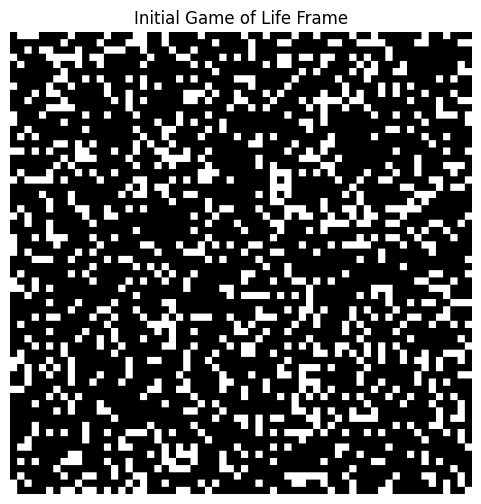


--- Starting Automated Generation with Action 'A' ---


Generating Frames:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------------
Step 1/10
Predicting frame 1 for action: 'A'...

[ERROR during prediction/decoding step 1]
MPS backend out of memory (MPS allocated: 8.24 GB, other allocations: 1.00 GB, max allowed: 9.07 GB). Tried to allocate 5.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Skipping to next step if possible...
------------------------------
Step 2/10
Predicting frame 2 for action: 'A'...

[ERROR during prediction/decoding step 2]
MPS backend out of memory (MPS allocated: 8.10 GB, other allocations: 1.00 GB, max allowed: 9.07 GB). Tried to allocate 256 bytes on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Traceback (most recent call last):
  File "/var/folders/_k/vbkl_k7n1v132xrv3mf0f83r0000gn/T/ipykernel_7501/4232640228.py", line 386, in <module>
    predicted_latent = predict_next_frame(
  File "/Users/chinmaysultanpuri/Library/Python/3.9/lib/python/site-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
  File "/var/folders/_k/vbkl_k7n1v132xrv3mf0f83r0000gn/T/ipykernel_7501/4232640228.py", line 317, in predict_next_frame
    predicted_next_latent = unet(
  File "/Users/chinmaysultanpuri/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/Users/chinmaysultanpuri/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/chinmaysultanpuri/Library/Python/3.9/lib/python/site-packages/diffusers/models/unets/unet_2d_condition.py", line 1214, 

Skipping to next step if possible...
------------------------------
Step 3/10
Predicting frame 3 for action: 'A'...

[ERROR during prediction/decoding step 3]
MPS backend out of memory (MPS allocated: 8.10 GB, other allocations: 1.00 GB, max allowed: 9.07 GB). Tried to allocate 256 bytes on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Skipping to next step if possible...
------------------------------
Step 4/10
Predicting frame 4 for action: 'A'...

[ERROR during prediction/decoding step 4]
MPS backend out of memory (MPS allocated: 8.10 GB, other allocations: 1.00 GB, max allowed: 9.07 GB). Tried to allocate 256 bytes on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Skipping to next step if possible...
------------------------------
Step 5/10
Predicting frame 5 for action: 'A'...

[ERROR during prediction/decoding step 5]

Traceback (most recent call last):
  File "/var/folders/_k/vbkl_k7n1v132xrv3mf0f83r0000gn/T/ipykernel_7501/4232640228.py", line 386, in <module>
    predicted_latent = predict_next_frame(
  File "/Users/chinmaysultanpuri/Library/Python/3.9/lib/python/site-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
  File "/var/folders/_k/vbkl_k7n1v132xrv3mf0f83r0000gn/T/ipykernel_7501/4232640228.py", line 308, in predict_next_frame
    action_emb = action_conditioner(action_string, device=DEVICE).to(dtype=INFERENCE_DTYPE)
  File "/Users/chinmaysultanpuri/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/Users/chinmaysultanpuri/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
  File "/var/folders/_k/vbkl_k7n1v132xrv3mf0f83r0000gn/T/ipykernel_7501/4232

In [6]:
# ==============================================================================
#                            Imports
# ==============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.notebook import tqdm # Use notebook version for better display

# Diffusers & Transformers
from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer

# Disable noisy warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0' # Suppress TensorFlow oneDNN warnings if TF is installed

# Game of Life Specific Imports
from scipy.signal import convolve2d

# ==============================================================================
#                      Configuration (MUST MATCH TRAINING)
# ==============================================================================

# --- Core Model & Paths ---
SD_MODEL_ID = "runwayml/stable-diffusion-v1-5"
CLIP_MODEL_NAME = "openai/clip-vit-large-patch14"
CHECKPOINT_DIR = "./training_diffusion/"
TARGET_EPOCH = 10
VAE_PATH = "./models/vae_full_finetuned_stage2_v10_api_fix_corrected.pth"

# --- Image & Latent Dimensions (Must match training) ---
IMAGE_RESOLUTION = 512
VAE_SCALE_FACTOR = 0.18215
LATENT_CHANNELS = 4
VAE_DOWNSAMPLE_FACTOR = 8
LATENT_HEIGHT = IMAGE_RESOLUTION // VAE_DOWNSAMPLE_FACTOR
LATENT_WIDTH = IMAGE_RESOLUTION // VAE_DOWNSAMPLE_FACTOR

# --- Action Conditioning Module Config (Must match training) ---
CLIP_MAX_LENGTH = 16
FREEZE_CLIP_IN_ACTION_MODULE = True

# --- Inference Specific Config ---
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
INFERENCE_DTYPE = torch.float32
NUM_INFERENCE_STEPS = 10

# --- Game of Life Parameters ---
GRID_SIZE = (64, 64)
INITIAL_ALIVE_PROB = 0.25

# Action to use for all steps.  Modify this for different effects.
ACTION_STRING = "A"

# ==============================================================================
#              Model Definitions (Copy EXACTLY from training)
# ==============================================================================

class ActionConditioningModule(nn.Module):
    """ Encodes action strings using CLIP and projects to target dimension. """
    def __init__(
        self,
        clip_model_name: str = CLIP_MODEL_NAME,
        max_clip_length: int = CLIP_MAX_LENGTH,
        target_token_dim: int = 768, # This will be updated based on UNet later
        freeze_clip: bool = FREEZE_CLIP_IN_ACTION_MODULE
    ):
        super().__init__()
        self.target_token_dim = target_token_dim
        self.max_clip_length = max_clip_length
        self.freeze_clip = freeze_clip
        print(f"[ActionConditioner] Initializing with CLIP: {clip_model_name}")
        self.clip_tokenizer = CLIPTokenizer.from_pretrained(clip_model_name)
        self.clip_text_model = CLIPTextModel.from_pretrained(clip_model_name)
        clip_output_dim = self.clip_text_model.config.hidden_size
        print(f"[ActionConditioner]   CLIP output dim: {clip_output_dim}")

        if freeze_clip:
            print("[ActionConditioner]   Freezing CLIP text model parameters.")
            for param in self.clip_text_model.parameters(): param.requires_grad = False
            self.clip_text_model.eval() # Ensure it's in eval mode if frozen
        else:
            print("[ActionConditioner]   CLIP text model parameters are TRAINABLE (will be set to eval).")
            # We still set to eval for inference regardless

        # Projection layers
        self.action_projection1 = nn.Linear(clip_output_dim, clip_output_dim)
        self.action_projection2 = nn.Linear(clip_output_dim, target_token_dim) # Target dim might change
        print(f"[ActionConditioner]   Added projection layers (target dim {target_token_dim} might update)")

    def forward(self, action_strings, device):
        b = len(action_strings)
        clip_inputs = self.clip_tokenizer(
            action_strings, padding="max_length", truncation=True,
            max_length=self.max_clip_length, return_tensors="pt"
        ).to(device)

        # Ensure eval mode and no gradients during inference
        self.clip_text_model.eval()
        with torch.no_grad():
            outputs = self.clip_text_model(**clip_inputs)
            last_hidden = outputs.last_hidden_state # [batch_size, seq_len, hidden_size]

            # --- Using pooled output (like training) ---
            eos_token_id = self.clip_tokenizer.eos_token_id
            input_ids = clip_inputs["input_ids"]
            batch_size, seq_len = last_hidden.shape[0], last_hidden.shape[1]
            eos_mask = (input_ids == eos_token_id)
            eos_indices = torch.where(
                eos_mask.any(dim=1),
                eos_mask.max(dim=1).indices,
                torch.tensor(seq_len - 1, device=device)
            )
            eos_indices = eos_indices.clamp(0, seq_len - 1)
            pooled = last_hidden[torch.arange(batch_size, device=device), eos_indices]
            # --- End Pooled Output ---

        # Projection layers (still no grad)
        with torch.no_grad():
            x = F.silu(self.action_projection1(pooled))
            x = self.action_projection2(x)

        # Return shape [batch_size, 1, target_token_dim] for UNet cross-attention
        return x.unsqueeze(1)

# ==============================================================================
#                     Game of Life Helper Functions
# ==============================================================================

def initialize_grid(size, alive_prob=INITIAL_ALIVE_PROB):
    """Initializes a random CGoL grid."""
    return np.random.choice([0, 1], size=size, p=[1 - alive_prob, alive_prob])

def step_grid(grid):
    """Performs one step of Conway's Game of Life using convolution."""
    kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    neighbor_counts = convolve2d(grid, kernel, mode='same', boundary='wrap')
    birth = (grid == 0) & (neighbor_counts == 3)
    survival = (grid == 1) & ((neighbor_counts == 2) | (neighbor_counts == 3))
    new_grid = np.zeros_like(grid)
    new_grid[birth | survival] = 1
    return new_grid

def render_grid_to_image(grid, image_resolution=IMAGE_RESOLUTION):
    """Renders the CGoL grid (0/1) to a PIL Image."""
    grid_h, grid_w = grid.shape
    scale_h = image_resolution // grid_h
    scale_w = image_resolution // grid_w
    black = np.array([0, 0, 0], dtype=np.uint8)
    white = np.array([255, 255, 255], dtype=np.uint8)
    bool_grid = grid.astype(bool)
    colored_grid = np.zeros((grid_h, grid_w, 3), dtype=np.uint8)
    colored_grid[~bool_grid] = black
    colored_grid[bool_grid] = white
    upscaled_frame_np = colored_grid.repeat(scale_h, axis=0).repeat(scale_w, axis=1)
    image = Image.fromarray(upscaled_frame_np)
    return image

@torch.no_grad()
def encode_image_to_latent(image, vae, device=DEVICE, dtype=INFERENCE_DTYPE):
    """Encodes a PIL Image to a latent tensor."""
    image = image.resize((IMAGE_RESOLUTION, IMAGE_RESOLUTION))  # Ensure correct size
    image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device).to(dtype) * 2 - 1 # Normalize to [-1, 1]
    latent = vae.encode(image_tensor).latent_dist.sample() * VAE_SCALE_FACTOR # Scale
    return latent

# ==============================================================================
#                        Loading Function (Corrected)
# ==============================================================================

def load_trained_models(checkpoint_dir, epoch, sd_model_id, vae_path=None):
    """Loads the trained UNet, ActionConditioner, and VAE."""
    print(f"\n--- Loading Models: Epoch {epoch} from '{checkpoint_dir}' ---")

    # --- 1. Load VAE ---
    print(f"[Load] Initializing VAE from {sd_model_id}...")
    try:
        vae = AutoencoderKL.from_pretrained(sd_model_id, subfolder="vae")
        if vae_path and os.path.exists(vae_path):
            abs_vae_path = os.path.abspath(vae_path)
            print(f"[Load] Loading custom VAE weights from: {abs_vae_path}")
            if os.path.exists(abs_vae_path):
                 vae.load_state_dict(torch.load(abs_vae_path, map_location='cpu'), strict=False)
                 print("[Load] Custom VAE weights applied.")
            else:
                 print(f"[Load Warning] Custom VAE path specified but not found at {abs_vae_path}. Using base VAE.")
        elif vae_path:
             print(f"[Load Warning] Custom VAE path '{vae_path}' specified but does not exist. Using base VAE.")
        else:
             print("[Load] Using base VAE weights.")

        vae = vae.to(DEVICE).to(dtype=INFERENCE_DTYPE)
        vae.eval()
        print(f"[Load] VAE Loaded to {DEVICE} ({INFERENCE_DTYPE}).") # Corrected print format
    except Exception as e:
        print(f"[Load Error] Failed to load VAE: {e}")
        raise e

    # --- 2. Load UNet ---
    print(f"\n[Load] Initializing UNet from {sd_model_id}...")
    try:
        unet = UNet2DConditionModel.from_pretrained(sd_model_id, subfolder="unet")
        unet_cross_attention_dim = unet.config.cross_attention_dim
        print(f"[Load] Base UNet loaded. Cross Attn Dim: {unet_cross_attention_dim}")

        # Construct the correct checkpoint filename
        unet_filename = f"unet_epoch_{epoch}.pth"
        unet_path = os.path.join(checkpoint_dir, unet_filename)
        unet_path_abs = os.path.abspath(unet_path)

        if not os.path.exists(unet_path_abs):
            raise FileNotFoundError(f"UNet checkpoint not found at expected path: {unet_path_abs}")

        print(f"[Load] Loading UNet weights from: {unet_path_abs}")
        unet_state_dict = torch.load(unet_path_abs, map_location='cpu')

        # Handle potential 'module.' prefix from DDP saving
        if all(key.startswith('module.') for key in unet_state_dict.keys()):
            print("[Load] Removing 'module.' prefix from UNet state_dict keys.")
            unet_state_dict = {k.partition('module.')[2]: v for k, v in unet_state_dict.items()}

        unet.load_state_dict(unet_state_dict)
        unet = unet.to(DEVICE).to(dtype=INFERENCE_DTYPE)
        unet.eval()
        print(f"[Load] UNet Loaded to {DEVICE} ({INFERENCE_DTYPE}).") # Corrected print format
    except Exception as e:
        print(f"[Load Error] Failed to load UNet: {e}")
        raise e

    # --- 3. Load Action Conditioner ---
    print(f"\n[Load] Initializing ActionConditioner...")
    try:
        action_conditioner = ActionConditioningModule(
            target_token_dim=unet_cross_attention_dim, # Use actual dim from loaded UNet
            freeze_clip=FREEZE_CLIP_IN_ACTION_MODULE
        )

        # Construct the correct checkpoint filename
        action_cond_filename = f"action_conditioner_epoch_{epoch}.pth"
        action_cond_path = os.path.join(checkpoint_dir, action_cond_filename)
        action_cond_path_abs = os.path.abspath(action_cond_path)

        if not os.path.exists(action_cond_path_abs):
            raise FileNotFoundError(f"ActionConditioner checkpoint not found at: {action_cond_path_abs}")

        print(f"[Load] Loading ActionConditioner weights from: {action_cond_path_abs}")
        action_cond_state_dict = torch.load(action_cond_path_abs, map_location='cpu')

        # Handle potential 'module.' prefix
        if all(key.startswith('module.') for key in action_cond_state_dict.keys()):
            print("[Load] Removing 'module.' prefix from ActionConditioner state_dict keys.")
            action_cond_state_dict = {k.partition('module.')[2]: v for k, v in action_cond_state_dict.items()}

        action_conditioner.load_state_dict(action_cond_state_dict)
        action_conditioner = action_conditioner.to(DEVICE).to(dtype=INFERENCE_DTYPE)
        action_conditioner.eval()
        print(f"[Load] ActionConditioner Loaded to {DEVICE} ({INFERENCE_DTYPE}).") # Corrected print format
    except Exception as e:
        print(f"[Load Error] Failed to load ActionConditioner: {e}")
        raise e

    print("\n--- Model Loading Complete ---")
    return vae, unet, action_conditioner

# ==============================================================================
#                     Image Processing Functions
# ==============================================================================

@torch.no_grad()
def decode_latent_to_pil(latents, vae):
    """Decodes latents (BCHW) to a PIL Image."""
    latents = latents.to(dtype=vae.dtype) # Match VAE dtype for decode
    # Scale latent before VAE decode
    latents = latents / VAE_SCALE_FACTOR
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1) # Denormalize [-1, 1] -> [0, 1]

    # Handle batch size > 1 if necessary, return first image
    if image.shape[0] > 1:
        print(f"Warning: Decoding batch of {image.shape[0]}, returning only the first image.")
    image = image[0].cpu().permute(1, 2, 0).float().numpy() # CHW -> HWC, float32 numpy
    image = (image * 255).round().astype(np.uint8)
    return Image.fromarray(image)

# ==============================================================================
#                     Core Prediction Function
# ==============================================================================

@torch.no_grad()
def predict_next_frame(current_latent, action_string, unet, action_conditioner):
    """
    Predicts the latent representation of the next frame using the trained models.
    Input: current_latent (BCHW tensor), action_string (str or list/tuple of strings)
    Output: predicted_next_latent (BCHW tensor)
    """
    unet.eval()
    action_conditioner.eval()

    # 1. Get Action Embedding
    if isinstance(action_string, str):
        action_string = [action_string] # Ensure it's a list for the conditioner
    action_emb = action_conditioner(action_string, device=DEVICE).to(dtype=INFERENCE_DTYPE)

    # 2. Prepare UNet inputs
    timestep = torch.tensor([1], device=DEVICE).long() # Using t=1
    bsz = current_latent.shape[0]
    if bsz != 1:
         timestep = timestep.repeat(bsz)

    # 3. UNet Prediction
    predicted_next_latent = unet(
        sample=current_latent.to(dtype=INFERENCE_DTYPE), # Input current state
        timestep=timestep,
        encoder_hidden_states=action_emb
    ).sample # Output is the predicted next state latent

    return predicted_next_latent

# ==============================================================================
#                       Inference Execution (No Interactive Input)
# ==============================================================================

if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using inference dtype: {INFERENCE_DTYPE}")

    # --- 1. Load Models ---
    try:
        vae, unet, action_conditioner = load_trained_models(
            CHECKPOINT_DIR, TARGET_EPOCH, SD_MODEL_ID, VAE_PATH
        )
    except FileNotFoundError as e:
        print(f"\n[FATAL ERROR] Could not find necessary checkpoint files.")
        print(e)
        print("\nPlease ensure CHECKPOINT_DIR and TARGET_EPOCH are correct and the files exist:")
        print(f"  - {os.path.join(CHECKPOINT_DIR, f'unet_epoch_{TARGET_EPOCH}.pth')}")
        print(f"  - {os.path.join(CHECKPOINT_DIR, f'action_conditioner_epoch_{TARGET_EPOCH}.pth')}")
    except Exception as e:
        print(f"\n[FATAL ERROR] An unexpected error occurred during model loading: {e}")
        import traceback
        traceback.print_exc()
    else: # Proceed only if models loaded successfully

        # --- 2. Initialize Latent State (Random Game of Life) ---
        print("\n--- Initializing Start Latent State (Random Game of Life) ---")
        try:
            # Generate random initial Game of Life frame
            initial_grid = initialize_grid(GRID_SIZE)
            initial_image = render_grid_to_image(initial_grid)

            # Encode image to latent
            current_latent = encode_image_to_latent(initial_image, vae)
            print(f"Encoded initial Game of Life frame to latent with shape: {current_latent.shape}")

            # Display the initial frame
            plt.figure(figsize=(6, 6))
            plt.imshow(initial_image)
            plt.title("Initial Game of Life Frame")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"\n[ERROR generating/encoding initial Game of Life frame]")
            print(e)
            import traceback
            traceback.print_exc()
            exit() # Exit if the initial frame fails.  It's critical.

        # --- 3. Generation Loop (Automated with "A") ---
        generated_frames_pil = []

        print("\n--- Starting Automated Generation with Action 'A' ---")
        for i in tqdm(range(NUM_INFERENCE_STEPS), desc="Generating Frames"):
            print("-" * 30)
            print(f"Step {i+1}/{NUM_INFERENCE_STEPS}")

            # Predict the next latent state (always action "A")
            print(f"Predicting frame {i+1} for action: '{ACTION_STRING}'...")
            try:
                predicted_latent = predict_next_frame(
                    current_latent, ACTION_STRING, unet, action_conditioner
                )

                # Decode the predicted latent to an image
                predicted_pil_image = decode_latent_to_pil(predicted_latent, vae)
                generated_frames_pil.append(predicted_pil_image)

                # Display the result
                plt.figure(figsize=(6, 6))
                plt.imshow(predicted_pil_image)
                plt.title(f"Generated Frame {i+1} - Action: '{ACTION_STRING}'")
                plt.axis('off')
                plt.show()

                # Update current latent for the next step
                current_latent = predicted_latent

            except Exception as e:
                print(f"\n[ERROR during prediction/decoding step {i+1}]")
                print(e)
                import traceback
                traceback.print_exc()
                print("Skipping to next step if possible...")
                continue # Try to continue if one step fails

        print("\n--- Inference Loop Finished ---")

        # Optional: Display all generated frames together at the end
        if generated_frames_pil: # Check if any frames were generated
             print("\nDisplaying Generated Sequence:")
             num_frames = len(generated_frames_pil)
             cols = min(num_frames, 5) # Display max 5 frames per row
             rows = (num_frames + cols - 1) // cols
             fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
             # Ensure axes is always iterable, even if rows*cols=1
             if rows * cols == 1:
                 axes = np.array([axes])
             axes = axes.flatten() # Make axes array 1D for easy iteration

             for idx, frame in enumerate(generated_frames_pil):
                 axes[idx].imshow(frame)
                 axes[idx].set_title(f"Frame {idx+1}") # Start numbering from 1
                 axes[idx].axis('off')
             # Hide any unused subplots
             for idx in range(num_frames, len(axes)):
                  axes[idx].axis('off')
             plt.tight_layout()
             plt.show()
        else:
             print("No frames were generated.")